In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

%matplotlib inline

# Getting data

In [3]:
df_listings = pd.read_csv('listings.csv')

# Exploring the dataset

In this part of the analysis I want to know some informations about the dataset, like:

- The shape of the dataset
- List of columns for each data type
- The number of missing values

#### Shape

In [4]:
df_listings.shape

(3818, 92)

#### List of columns

In [5]:
# First I need to know the different Data types in dataset
df_listings.dtypes.value_counts().index

Index([object, float64, int64], dtype='object')

In [6]:
# Ensuring that all columns are shown in below visualizations
pd.set_option('display.max_rows', len(df_listings.columns))

In [7]:
df_listings.dtypes[df_listings.dtypes == 'float64']

host_listings_count            float64
host_total_listings_count      float64
latitude                       float64
longitude                      float64
bathrooms                      float64
bedrooms                       float64
beds                           float64
square_feet                    float64
review_scores_rating           float64
review_scores_accuracy         float64
review_scores_cleanliness      float64
review_scores_checkin          float64
review_scores_communication    float64
review_scores_location         float64
review_scores_value            float64
license                        float64
reviews_per_month              float64
dtype: object

In [8]:
df_listings.dtypes[df_listings.dtypes == 'int64']

id                                int64
scrape_id                         int64
host_id                           int64
accommodates                      int64
guests_included                   int64
minimum_nights                    int64
maximum_nights                    int64
availability_30                   int64
availability_60                   int64
availability_90                   int64
availability_365                  int64
number_of_reviews                 int64
calculated_host_listings_count    int64
dtype: object

In [9]:
df_listings.dtypes[df_listings.dtypes == 'object']

listing_url                         object
last_scraped                        object
name                                object
summary                             object
space                               object
description                         object
experiences_offered                 object
neighborhood_overview               object
notes                               object
transit                             object
thumbnail_url                       object
medium_url                          object
picture_url                         object
xl_picture_url                      object
host_url                            object
host_name                           object
host_since                          object
host_location                       object
host_about                          object
host_response_time                  object
host_response_rate                  object
host_acceptance_rate                object
host_is_superhost                   object
host_thumbn

#### Missing values

In [10]:
df_listings.isnull().sum().sort_values(ascending=False)

license                             3818
square_feet                         3721
monthly_price                       2301
security_deposit                    1952
weekly_price                        1809
notes                               1606
neighborhood_overview               1032
cleaning_fee                        1030
transit                              934
host_about                           859
host_acceptance_rate                 773
review_scores_accuracy               658
review_scores_checkin                658
review_scores_value                  656
review_scores_location               655
review_scores_cleanliness            653
review_scores_communication          651
review_scores_rating                 647
reviews_per_month                    627
first_review                         627
last_review                          627
space                                569
host_response_time                   523
host_response_rate                   523
neighbourhood   

# Questions

For this analysis I want to answer three questions: 

    1) What are the most common amenities that are available in Seattle Airbnb dataset?
    2) What most attracts the guests for renting a property?
    3) What are the most influential features of the dataset to estimate the price of a listing?

### Question 1

If we look into 'object' type columns there is the column 'amenities'. This column gives the features of the listing.

I will treat the information in this column and then answer the question.

For this, first I will get a list of amenities available in dataset and count the occurrences to know the most common amenities.

In [33]:
# A list to store unique amenities avaible
list_of_amenities = []

# For each row
for i in range(len(df_listings)):
    # remove '{' and '}' and split the values by ','
    listing_amenities = df_listings['amenities'][i].replace('{','').replace('}','').split(',')
    
    # Store all values in the list
    for amenity in listing_amenities:
        list_of_amenities.append(amenity)

# Get just unique values     
list_of_amenities = list(set(list_of_amenities))

# Remove empty value
list_of_amenities.remove('')

In [34]:
dict_amenities = {}
count = 0

# For each item in amenities list
for amenity in list_of_amenities:
    # For each listing
    for i in range(len(df_listings)):
        if amenity in df_listings['amenities'][i]:
            # Counting occurrences of each amenities in listing dataset
            count += 1
    dict_amenities[amenity] = count
    count = 0

df_amenities = pd.DataFrame(pd.Series(dict_amenities)).reset_index()
df_amenities.rename(columns={'index':'amenities', 0: 'count'}, inplace=True)
df_amenities.set_index('amenities', inplace=True)
df_amenities.sort_values('count', ascending = False, inplace = True)

df_amenities.head()

,count
amenities,
Internet,3692
"""Wireless Internet""",3667
Heating,3627
Kitchen,3423
"""Smoke Detector""",3281


In [35]:
(df_amenities/len(df_listings)).head()

,count
amenities,
Internet,0.966998
"""Wireless Internet""",0.960450
Heating,0.949974
Kitchen,0.896543
"""Smoke Detector""",0.859350


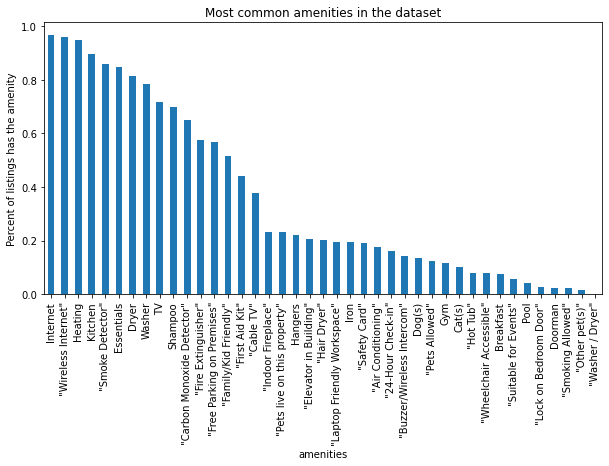

In [36]:
# Plotting a bar chart visualization to analyze amenities from the most common to the least common.
(df_amenities/len(df_listings))[:len(list_of_amenities)].plot(kind='bar', legend=None,figsize=(10,5));
plt.title('Most common amenities in the dataset');
plt.ylabel('Percent of listings has the amenity')
plt.show()

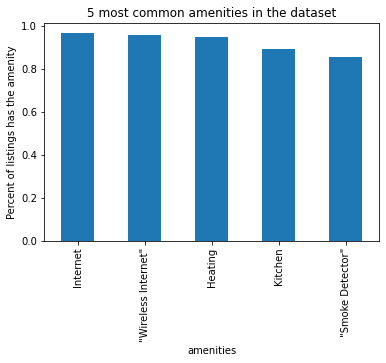

In [37]:
# The 5 most common
(df_amenities/len(df_listings))[:5].plot(kind='bar', legend=None);
plt.title('5 most common amenities in the dataset');
plt.ylabel('Percent of listings has the amenity')
plt.show()

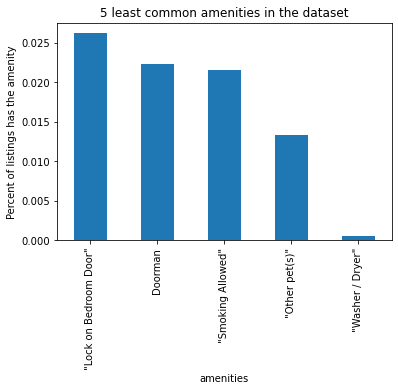

In [38]:
# The 5 least common
(df_amenities/len(df_listings))[-5:].plot(kind='bar', legend=None);
plt.title('5 least common amenities in the dataset');
plt.ylabel('Percent of listings has the amenity')
plt.show()

### Question 2

Here I will analyze the dataset to find the most important features for renting a property.

First I need to know the popularity of the listings, select the most popular ones and then analyze their features.

In [39]:
# Checking null values
print('Null values: ' + str(df_listings['availability_30'].isnull().sum()))

Null values: 0


In [40]:
# This will give me the percentage of booking for the next 30 days
df_listings['booking_ratio_30'] = 1 - (df_listings['availability_30']/30)
df_listings['booking_ratio_30'].head()

0    0.533333
1    0.566667
2    0.966667
3    1.000000
4    0.000000
Name: booking_ratio_30, dtype: float64

Now that I have the popularity of each listing (booking ratio) I need to investigate some feature to discover what attract the guests for choosing certain listing.

#### Room Type

In [41]:
# Checking null values
print('Null values: ' + str(df_listings['room_type'].isnull().sum()))

Null values: 0


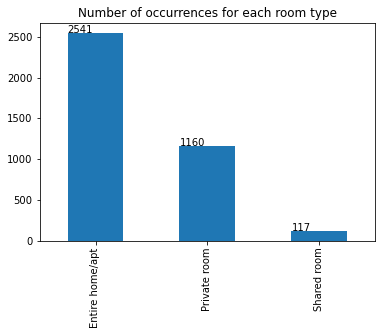

In [42]:
ax = df_listings['room_type'].value_counts().sort_values(ascending=False).plot(kind='bar', legend=None, label = True)

plt.title('Number of occurrences for each room type')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()

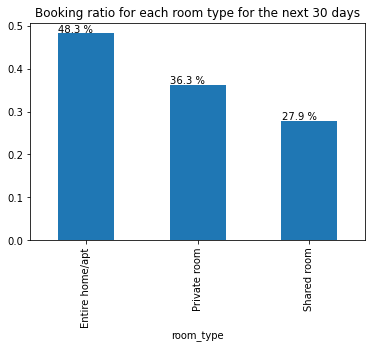

In [43]:
ax = df_listings.groupby(['room_type'])['booking_ratio_30'].mean().sort_values(ascending=False).plot(kind='bar', legend=None)

plt.title('Booking ratio for each room type for the next 30 days')

for p in ax.patches:
    ax.annotate("{:.1f} %".format(p.get_height()*100), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()

#### Property Type

In [44]:
# Checking null values
print('Null values: ' + str(df_listings['property_type'].isnull().sum()))

Null values: 1


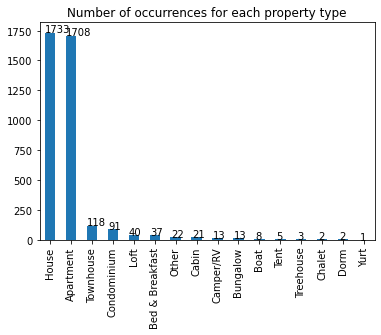

In [45]:
ax = df_listings['property_type'].value_counts().sort_values(ascending=False).plot(kind='bar', legend=None, label = True)

plt.title('Number of occurrences for each property type')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()

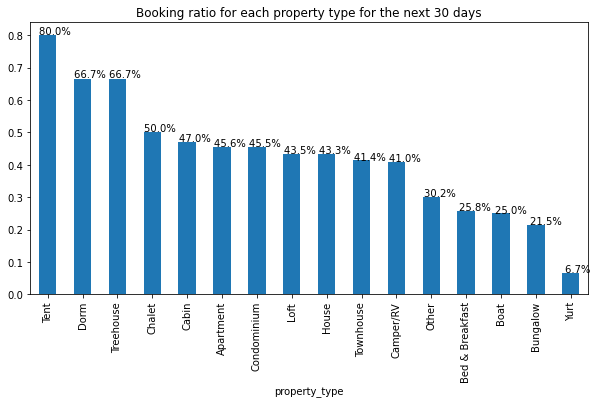

In [72]:
ax = df_listings.groupby(['property_type'])['booking_ratio_30'].mean().sort_values(ascending=False).plot(kind='bar', legend=None,figsize=(10,5))

plt.title('Booking ratio for each property type for the next 30 days')

for p in ax.patches:
    ax.annotate("{:.1f}% ".format(p.get_height()*100), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()

#### Amenities

In [47]:
# Checking null values
print('Null values: ' + str(df_listings['amenities'].isnull().sum()))

Null values: 0


Each listing have a set of amenities and each one is a feature. Because of this I will create a column for each and fill with 1 if the listing have the feature or 0 otherwise. Like a dummy variable.

In [48]:
# Creating the columns with 0s
for amenity in list_of_amenities:
    df_listings[amenity] = 0
    # Filling with 1 if the listing have the column respective feature
    for listing in range(len(df_listings)):
        if amenity in df_listings['amenities'][listing]:
            df_listings.loc[listing , amenity] = 1

To vizualize the booking ratio according to each one of the amenities I will create a dataframe with this information.

- A column with the booking ratio if have the amenity
- A column with the booking ratio if does not have the amenity
- The difference between them

The difference will show if a certain amenity influences the booking ratio

In [49]:
amenities_importance = pd.DataFrame(data = {'amenity':list_of_amenities})

# A column with the booking ratio if have the amenity
amenities_importance['br_having_amenity'] = amenities_importance['amenity'].apply(lambda amenity: df_listings.groupby(amenity)['booking_ratio_30'].mean()[1])
# A column with the booking ratio if does not have the amenity
amenities_importance['br_not_having_amenity'] = amenities_importance['amenity'].apply(lambda amenity: df_listings.groupby(amenity)['booking_ratio_30'].mean()[0])
# The difference between them
amenities_importance['booking_diff'] = amenities_importance['br_having_amenity'] - amenities_importance['br_not_having_amenity']


amenities_importance.set_index('amenity', inplace=True)
amenities_importance.sort_values(by='booking_diff', ascending = False, inplace = True)

In [74]:
amenities_importance.head(10)

,br_having_amenity,br_not_having_amenity,booking_diff
amenity,,,
"""Washer / Dryer""",0.616667,0.440365,0.176302
Kitchen,0.451154,0.347764,0.103390
Cat(s),0.486649,0.435322,0.051327
"""Pets Allowed""",0.479590,0.434937,0.044653
"""Other pet(s)""",0.483660,0.439873,0.043788
Dryer,0.448523,0.404782,0.043741
Washer,0.449543,0.407546,0.041997
"""Smoke Detector""",0.445992,0.406642,0.039350
"""Pets live on this property""",0.464477,0.433231,0.031246


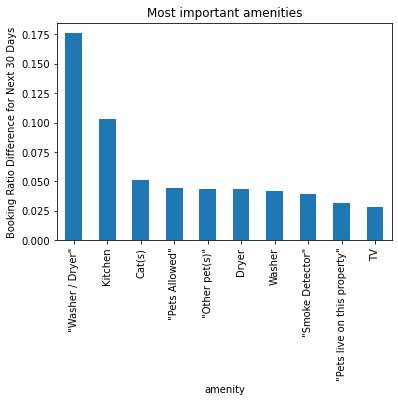

In [50]:
# Vizualization of most important amenities 
amenities_importance['booking_diff'][:10].plot(kind='bar', legend=None)
plt.title('Most important amenities');
plt.ylabel('Booking Ratio Difference for Next 30 Days')
plt.show()

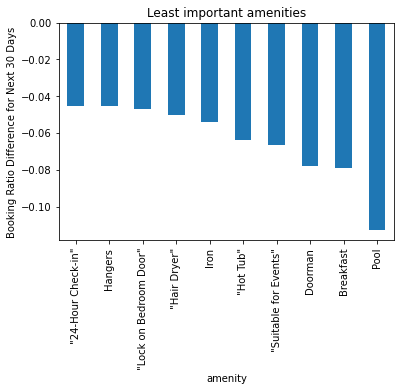

In [51]:
# Vizualization of least important amenities 
amenities_importance['booking_diff'][-10:].plot(kind='bar', legend=None)
plt.title('Least important amenities');
plt.ylabel('Booking Ratio Difference for Next 30 Days')
plt.show()

Answering the question 2 we can say that an "Entire home/apt is more popular than a private room or a shared room. And having a Washer/Dryer and a Kitchen increases the booking rate for the next 30 days. Allowing pets are also a good idea.

### Question 3

Now I want to know what are the most influencial features of the dataset to estimate the price of a listing and make a model to do it.

The supervised model need to have a label and this case the label are the prices. Having this in mind I need to know the types of prices, proportion of null values in dataset and handlig with this if necessary.

In [52]:
# Missing values for each price type

list_price_types = ['price', 
                    'weekly_price',
                    'monthly_price',
                    'security_deposit',
                    'cleaning_fee']

for price_type in list_price_types:
    print('{}: {}'.format(price_type, df_listings[price_type].isnull().sum()))

price: 0
weekly_price: 1809
monthly_price: 2301
security_deposit: 1952
cleaning_fee: 1030


weekly_price and monthly_price have a big proportion of null values and delete then maybe will affect the accuracy of the model.

So it is a better idea to model the "price".

I made a list of important features in my opinion for estimating the price of a listing.

In [53]:
features_of_interest = ['bathrooms', 'bedrooms', 'beds', 'latitude', 'longitude', 'square_feet', 'reviews_per_month',
        'booking_ratio_30', 'accommodates', 'guests_included', '"24-Hour Check-in"', '"Suitable for Events"',
       '"Pets live on this property"', 'Dog(s)', '"Smoking Allowed"',
       '"Other pet(s)"', 'Essentials', '"Wireless Internet"',
       '"Buzzer/Wireless Intercom"', 'TV', 'Gym', 'Washer', 'Doorman', 'Dryer',
       '"Hot Tub"', '"Air Conditioning"', '"Pets Allowed"', 'Pool',
       '"Hair Dryer"', '"Fire Extinguisher"', 'Breakfast', '"Washer / Dryer"',
       '"Laptop Friendly Workspace"', '"Free Parking on Premises"',
       '"Lock on Bedroom Door"', 'Cat(s)', 'Hangers', '"Family/Kid Friendly"',
       '"Carbon Monoxide Detector"', '"Safety Card"', 'Kitchen',
       '"Elevator in Building"', 'Internet', 'Shampoo', '"Smoke Detector"',
       '"Wheelchair Accessible"', 'Iron', '"First Aid Kit"',
       '"Indoor Fireplace"', '"Cable TV"', 'Heating', 'host_is_superhost', 'neighbourhood_group_cleansed',
        'property_type','room_type','bed_type','price','security_deposit',
        'cleaning_fee', 'extra_people', 'instant_bookable', 'cancellation_policy']

# New dataset with the columns of interest for the ml model
df_listings_ml = df_listings[features_of_interest]

In [54]:
features_of_interest = ['bathrooms', 'bedrooms', 'beds', 'square_feet', 'reviews_per_month',
                        'booking_ratio_30', 'accommodates', 'guests_included', '"24-Hour Check-in"', 
                        '"Suitable for Events"', '"Smoking Allowed"', 'Essentials', '"Wireless Internet"', 
                        'TV', 'Gym', 'Washer', 'Doorman', 'Dryer', '"Air Conditioning"', '"Pets Allowed"', 
                        'Pool', 'Breakfast', '"Washer / Dryer"', '"Lock on Bedroom Door"', '"Family/Kid Friendly"',
                        'Kitchen','"Elevator in Building"', 'Internet', 'Heating', 'host_is_superhost', 
                        'neighbourhood_group_cleansed', 'property_type','room_type','bed_type','price',
                        'security_deposit', 'cleaning_fee', 'extra_people', 'instant_bookable', 
                        'cancellation_policy']

# New dataset with the columns of interest for the ml model
df_listings_ml = df_listings[features_of_interest]

#### Handling with null values

In [55]:
# Checking null values
df_listings_ml.isnull().sum()[df_listings_ml.isnull().sum()>0]

bathrooms              16
bedrooms                6
beds                    1
square_feet          3721
reviews_per_month     627
host_is_superhost       2
property_type           1
security_deposit     1952
cleaning_fee         1030
dtype: int64

Strategy to handle with null values in each column:

- On square_feet I will drop the entire column because almost all values are missing and the characteristics of the listing maybe can replace this feature.

- Columns that are float types and have a small proportion of Nulls I will fill then with the mean of the column. Like: bathrooms, bedrooms, beds and reviews_per_month.

- Categorical columns with a small proportion of Nulls I will fill then with the mode of the column. Like: host_is_superhost and property_type.

- security_deposit and cleaning_fee are object data type that need to be converted to float first and then fill with the mean.

In [56]:
# Dropping square_feet column
df_listings_ml = df_listings_ml.drop(columns='square_feet')

In [57]:
# Filling with the column mean

df_listings_ml['bathrooms'].fillna(df_listings_ml['bathrooms'].mean(), inplace=True)
df_listings_ml['bedrooms'].fillna(df_listings_ml['bedrooms'].mean(), inplace=True)
df_listings_ml['beds'].fillna(df_listings_ml['beds'].mean(), inplace=True)
df_listings_ml['reviews_per_month'].fillna(df_listings_ml['reviews_per_month'].mean(), inplace=True)

In [58]:
# Filling with column mode
df_listings_ml['host_is_superhost'].fillna(df_listings_ml['host_is_superhost'].mode()[0], inplace=True)
df_listings_ml['property_type'].fillna(df_listings_ml['property_type'].mode()[0], inplace=True)

In [59]:
# Filling with 0

df_listings_ml['security_deposit'].fillna(0, inplace=True)
df_listings_ml['cleaning_fee'].fillna(0, inplace=True)

#### Changing data types and creating columns

Here I will chenge some columns data types and creating new columns for categorical data.

In [60]:
# Checking the dataset data types.
df_listings_ml.dtypes

bathrooms                       float64
bedrooms                        float64
beds                            float64
reviews_per_month               float64
booking_ratio_30                float64
accommodates                      int64
guests_included                   int64
"24-Hour Check-in"                int64
"Suitable for Events"             int64
"Smoking Allowed"                 int64
Essentials                        int64
"Wireless Internet"               int64
TV                                int64
Gym                               int64
Washer                            int64
Doorman                           int64
Dryer                             int64
"Air Conditioning"                int64
"Pets Allowed"                    int64
Pool                              int64
Breakfast                         int64
"Washer / Dryer"                  int64
"Lock on Bedroom Door"            int64
"Family/Kid Friendly"             int64
Kitchen                           int64


Changing column from object to float type.

- price
- security_deposit
- cleaning_fee

In [61]:
# Removing '$' and ','.
# Changing type to float

df_listings_ml['price'] = df_listings_ml['price'].str.replace('$','')
df_listings_ml['price'] = df_listings_ml['price'].str.replace(',','')
df_listings_ml['price'] = df_listings_ml['price'].astype(float)

df_listings_ml['security_deposit'] = df_listings_ml['security_deposit'].str.replace('$','')
df_listings_ml['security_deposit'] = df_listings_ml['security_deposit'].str.replace(',','')
df_listings_ml['security_deposit'] = df_listings_ml['security_deposit'].astype(float)

df_listings_ml['cleaning_fee'] = df_listings_ml['cleaning_fee'].str.replace('$','')
df_listings_ml['cleaning_fee'] = df_listings_ml['cleaning_fee'].str.replace(',','')
df_listings_ml['cleaning_fee'] = df_listings_ml['cleaning_fee'].astype(float)

df_listings_ml['extra_people'] = df_listings_ml['extra_people'].str.replace('$','')
df_listings_ml['extra_people'] = df_listings_ml['extra_people'].str.replace(',','')
df_listings_ml['extra_people'] = df_listings_ml['extra_people'].astype(float)

In [62]:
# Filling the missing values with mean
df_listings_ml['security_deposit'].fillna(df_listings_ml['security_deposit'].mean(), inplace=True)
df_listings_ml['cleaning_fee'].fillna(df_listings_ml['cleaning_fee'].mean(), inplace=True)

Now I will create dummy variables for categorical columns.

In [63]:
categorical_cols = df_listings_ml.select_dtypes(include=['object'])

In [64]:
# Dropping the original column and concat the dummys
for column in categorical_cols:
    try:
        df_listings_ml = pd.concat([df_listings_ml.drop(column, axis=1), pd.get_dummies(df_listings_ml[column], prefix=column, prefix_sep='_', drop_first=True)], axis=1)
    except:
        continue

#### Creating Linear Model

In [65]:
# Separating features from labels
y = df_listings_ml['price']
X = df_listings_ml.drop(columns='price')

In [66]:
# Separating train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [67]:
# Creating linear regression model
lr_model = LinearRegression(normalize=True)

# Training the model
lr_model.fit(X_train, y_train)

# Predicting and testing
y_test_preds = lr_model.predict(X_test)
test_score = r2_score(y_test, y_test_preds)
print(test_score)

0.6275332604763101


The r-squared value is 0.6250 which is not too high. I want to know about the coefficients of my model to discover which one has more influence.

In [77]:
# Function taken from Udacity notebook
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = coefficients
    coefs_df['abs_coefs'] = np.abs(coefficients)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

coef_df = coef_weights(lr_model.coef_, X_train)

coef_df.head(15)

,est_int,coefs,abs_coefs
49,property_type_Boat,167.564485,167.564485
64,room_type_Shared room,-70.568787,70.568787
52,property_type_Camper/RV,66.139535,66.139535
26,Internet,-39.422023,39.422023
11,"""Wireless Internet""",37.918330,37.918330
63,room_type_Private room,-35.965817,35.965817
57,property_type_Loft,34.154906,34.154906
15,Doorman,30.533379,30.533379
37,neighbourhood_group_cleansed_Downtown,28.258607,28.258607
34,neighbourhood_group_cleansed_Cascade,27.992819,27.992819


In order to increase r-squared value I will use SelectKBest. the below function tests different "k" numbers and compare r-squared for each k value.

In [69]:
def find_optimal_number_of_selectors(X, y, k_samples, plot=True):
    '''
    INPUT:
    X dataframe that contains the features.
    y dataframe that contains the variable to be predicted.
    k_samples is a list of k values that will be tested.
    
    OUTPUT:
    A dictionary that contains values of tested k-values as keys and r-squared values for each key.
    The k-value that has the highest r-squared.

    '''   
    result_r_squareds = []
    results = {}
    for kes in k_samples:
        selector = SelectKBest(score_func=f_regression, k=kes)
        selector.fit_transform(X, y)
        selected_cols = selector.get_support(indices=True)
        features_new_X = X.iloc[:,selected_cols]
        
        X_train, X_test, y_train, y_test = train_test_split(features_new_X, y, test_size = 0.2, random_state=42)
        lm_model = LinearRegression(normalize=True)
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        result_r_squareds.append(r2_score(y_test, y_test_preds))
        results[str(kes)] = r2_score(y_test, y_test_preds)
    
    if plot:
        plt.plot(k_samples, result_r_squareds, label="r-squared", alpha=0.5)
        plt.xlabel("Different k_values")
        plt.ylabel("R_Squared_Values")
        plt.legend(loc=1)
        plt.show()
    
    best_k = max(results, key=results.get)
    
    return results, best_k

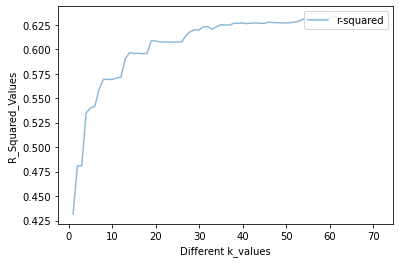

{'1': 0.4317160787014319, '2': 0.4810497033252711, '3': 0.48100500645301514, '4': 0.5350015104087117, '5': 0.5399977300127428, '6': 0.5417904629126549, '7': 0.5595100882768916, '8': 0.5695355973251741, '9': 0.5692215368829949, '10': 0.5692441656057619, '11': 0.5707661816331344, '12': 0.5716120189130038, '13': 0.5904062359373763, '14': 0.5965836933269102, '15': 0.595797188020206, '16': 0.5959743954370088, '17': 0.5956716781378978, '18': 0.5957250118628633, '19': 0.608688651925571, '20': 0.6086566955992623, '21': 0.6075358280359404, '22': 0.6075377056348734, '23': 0.6075514075513045, '24': 0.6072904796261283, '25': 0.6073740804004728, '26': 0.6075641819596106, '27': 0.6144117175297608, '28': 0.6182775814817392, '29': 0.6200258947740447, '30': 0.6199441455863907, '31': 0.6231913735712504, '32': 0.6231344011654198, '33': 0.6205455253261449, '34': 0.6231457478032778, '35': 0.6251661019498707, '36': 0.6249423453674646, '37': 0.624798800586181, '38': 0.6267208111978761, '39': 0.62663171612333

In [70]:
# I tested a range of k values and find the number of features that generate the highest r-squared value
k_samples = range(1, len(X.columns))
emre_results, emre_best_k = find_optimal_number_of_selectors(X, y, k_samples)
print(emre_results)
print(emre_best_k)
print(emre_results[emre_best_k])

The highest r-squared value is achieved with 61 features and the r-squared value is 0,6337